## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


User-User рекомендации - поиск 'похожего' user-a , и рекомендации на основе оценок 'похожего'user-a
Item-Item рекомендации - поиск похожего продукта и рекомендации на его основе
Похожи алгоритмом 1) поиск похожего 2) предсказание на основе оценок похожего
Поиск похожего в том и другом случае осуществляется сравнением двух векторов
В item-item есть один нюанс: разные пользователи по-разному относятся к оценкам, кто-то ставит всем подряд по пять звёздочек («лайкает» все подряд сайты), а кто-то, наоборот, ставит всем по две-три звёздочки (часто жмёт «дизлайк»). Для первого пользователя низкий рейтинг («дизлайк») будет гораздо более информативен, чем высокий, а для второго – наоборот. В user-user подходе об этом автоматически заботится коэффициент корреляции. А в item-based рекомендациях, чтобы это учесть, можно, например, вычесть из каждой оценки средний рейтинг того или иного пользователя

основные проблемы для всех - разреженность данных, холодный старт и масштабируемость
Использование item-item  позволяет повысить качество рекомендаций для новых пользователей, а так же повышает произволительность рекомендательной системы в случае, когда количество пользователей значительно превышает количество объектов

Использовать функцию можно, но лучше учитывать особенности каждого метода рекомендаций

ALS —  алгоритм разложения матрицы предпочтений на произведение 2 матриц: факторов пользователей (U) и факторов товаров (I). Работает по принципу минимизации среднеквадратичной ошибки на проставленных рейтингах. Оптимизация происходит поочередно, сначала по факторам пользователей, потом по факторам товаров. Также для обхода переобучения к среднеквадратичной ошибке добавляются регуляризационные коэффиценты.


2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


- частота появления в чеке
- размер скидки
- давность покупки(товары которые давно не покупал

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


матрица для ALS должна состоять из рейтингов - числа. Должны быть именно рейтинги, а не факты взаимодествия

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

BM25 — поисковая функция на неупорядоченном множестве термов («мешке слов») и множестве документов, которые она оценивает на основе встречаемости слов запроса в каждом документе, без учёта взаимоотношений между ними (например, близости). Это не одна функция, а семейство функций с различными компонентами и параметрами. Одна из распространенных форм этой функции описана ниже.
В функцию БМ25 внедрены свободные коэффициенты, которые могут принимать различные значения. Они подбираются так, чтобы «подогнать» результат работы поиска под заранее имеющиеся данные. Документы сначала оценивают асессоры, которые и говорят что плохо, а что хорошо. Затем на основании этих данных выбирают упомянутые коэффициенты, чтобы расположить документы так же, как это сделали асессоры – так называемый «принцип обезьянки». Оценка релевантности документа
Существует целое семейство похожих преобразований (например, BM25 и аналогичные), но содержательно все они повторяют ту же логику, что TF-IDF: редкие атрибуты должны иметь больший вес при сравнении товаров.
https://habr.com/ru/company/lanit/blog/420499/
https://habr.com/ru/post/162937/
http://docplayer.ru/126621148-Tekstovoe-ranzhirovanie-i-bm-25.html
https://ru.wikipedia.org/wiki/Okapi_BM25
http://webline.blog/algoritm-okapi-bm25-modifikacziya-formuly-tf-idf-ranzhirovaniya-dokumentov/
способы перевзвешивания 
- TF-IDF
- BM25
- BM25F

## Практическая часть


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
import time

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [150]:
data = pd.read_csv('../lesson2/retail_train.csv')
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [151]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [152]:
popularity = data_train.groupby('item_id')['sales_value'].sum().reset_index()
popularity.rename(columns={'sales_value': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [153]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,259120,397896,420647,480014,818981,819063,819255,819304,819308,819330,...,15926844,15926886,15971546,15972074,15972298,15972565,15972790,16053266,16100266,16769635
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
user_item_matrix.shape

(2499, 5001)

In [155]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [156]:
csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [157]:
%%time

model = AlternatingLeastSquares(factors=100, #размерность вектора пользователя и товара
                                regularization=0.001, #коэффициент регуляризации лямбда
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) #число потоков

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 14.9 s, sys: 1.8 s, total: 16.7 s
Wall time: 6.63 s


In [158]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [159]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    recommended_list = recommended_list[:k]
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    precision = flags.sum()/len(recommended_list)
    
    return precision

In [160]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 38 s, sys: 3 s, total: 41 s
Wall time: 20.8 s


0.16111655239960823

In [162]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 979707, 1105488, 5569374, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 5568378, 1133018, 914190, 5569327]"


### 2. TF-IDF взвешивание

In [163]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [164]:
print(user_item_matrix)

  (19, 0)	3.128321441602403
  (67, 0)	2.207474893192388
  (984, 0)	2.8790385020851588
  (1181, 0)	10.458773938402837
  (1246, 0)	2.5159782934577537
  (1419, 0)	3.114715789546625
  (1691, 0)	2.758491397541624
  (2143, 0)	4.3127005520279384
  (2490, 0)	2.964433586497287
  (19, 1)	3.128321441602403
  (31, 1)	9.330664199876356
  (67, 1)	2.207474893192388
  (114, 1)	2.255901487097862
  (130, 1)	3.2397603347648696
  (192, 1)	2.9919402322871207
  (211, 1)	4.621230012098151
  (255, 1)	2.574593796292203
  (324, 1)	2.8236610326162044
  (350, 1)	2.397095752467954
  (351, 1)	5.15009734143243
  (382, 1)	2.995932253556658
  (403, 1)	2.733567989089167
  (485, 1)	14.132192044945754
  (517, 1)	2.3839951284222556
  (525, 1)	3.64474219066859
  :	:
  (2019, 4999)	2.037348609492251
  (2112, 4999)	3.0161349608741768
  (2234, 4999)	2.922681791817065
  (2266, 4999)	3.204187192377117
  (2273, 4999)	2.4037109915866726
  (2281, 4999)	3.8445643369569984
  (2298, 4999)	2.9919402322871207
  (2311, 4999)	2.386166681

In [165]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()


CPU times: user 54.7 s, sys: 5.54 s, total: 1min
Wall time: 28.4 s


0.16190009794319296

### 3. BM25 взвешивание

In [167]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,259120,397896,420647,480014,818981,819063,819255,819304,819308,819330,...,15926844,15926886,15971546,15972074,15972298,15972565,15972790,16053266,16100266,16769635
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [169]:
print(user_item_matrix)

  (19, 0)	13.36898011975866
  (67, 0)	9.433713418797142
  (984, 0)	12.303661633531117
  (1181, 0)	94.31116232009599
  (1246, 0)	10.752112407525427
  (1419, 0)	13.310835937568456
  (1691, 0)	11.788499789001646
  (2143, 0)	18.430461517087796
  (2490, 0)	12.668600213898381
  (19, 1)	7.871597390611639
  (31, 1)	58.72937145559752
  (67, 1)	5.554529460435917
  (114, 1)	5.67638223590623
  (130, 1)	11.248439636758487
  (192, 1)	7.528429979137215
  (211, 1)	19.184575562721612
  (255, 1)	6.478287537612436
  (324, 1)	7.104999671941771
  (350, 1)	6.031660435926251
  (351, 1)	12.95886421871345
  (382, 1)	7.538474849779556
  (403, 1)	6.878304244512666
  (485, 1)	88.95130489214881
  (517, 1)	5.998696164198254
  (525, 1)	12.654535609732994
  :	:
  (2019, 4999)	6.022146265253229
  (2112, 4999)	8.915315624190042
  (2234, 4999)	8.63907980946925
  (2266, 4999)	9.47117437037693
  (2273, 4999)	7.105067391652432
  (2281, 4999)	11.364048673585337
  (2298, 4999)	8.843799049304181
  (2311, 4999)	7.0532086187608

In [170]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()


CPU times: user 53.1 s, sys: 4.69 s, total: 57.8 s
Wall time: 27.1 s


0.1920666013712047

In [172]:
data_test.loc[~data_test['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix_test = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix_test = user_item_matrix_test.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix_test).tocsr()

user_item_matrix_test.head(3)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,397896,480014,818981,819063,819255,819304,819308,819330,819518,819765,...,15924983,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16053266,16100266
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
user_item_matrix_test = bm25_weight(user_item_matrix_test.T).T

In [174]:
print(user_item_matrix_test)

  (416, 0)	14.814058279581955
  (1150, 0)	19.326705244062897
  (1413, 0)	13.488197809780488
  (1668, 0)	15.088051266579377
  (738, 1)	36.289074881165504
  (608, 2)	15.23582570795805
  (1518, 2)	16.93090530732489
  (1773, 2)	16.706563124218693
  (51, 3)	7.646563599339957
  (923, 3)	9.096032955616149
  (944, 3)	7.646563599339957
  (1160, 3)	10.46369112538705
  (1173, 3)	7.676801115113562
  (1244, 3)	9.650846629988669
  (1259, 3)	7.269936184154541
  (1451, 3)	7.770744514517917
  (1452, 3)	9.312898269032958
  (1548, 3)	7.5026752349581916
  (1571, 3)	7.421644963921208
  (1950, 3)	8.471944303118304
  (4, 4)	15.214381553675581
  (1741, 4)	19.083291998026468
  (216, 5)	8.345240202151423
  (282, 5)	7.235625965551056
  (377, 5)	6.232467031352618
  :	:
  (1790, 4446)	9.21419902136865
  (367, 4447)	13.507449592058835
  (371, 4447)	22.638408872115807
  (826, 4447)	11.137505433376422
  (1505, 4447)	10.458912237579332
  (1725, 4447)	13.300422781793037
  (68, 4448)	6.263105984664448
  (236, 4448)	7.36

In [175]:
result.head(3)

,user_id,actual,als,als_tfidf,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 979707, 1105488, 5569374, 995242]","[965766, 979707, 1033142, 999999, 1082185]","[999999, 1082185, 995242, 965766, 1004390]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 5568378, 1133018, 914190, 5569327]","[1106523, 951590, 952317, 1133018, 999999]","[999999, 951590, 1133018, 1053690, 1106523]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[981760, 930118, 1024306, 1127831, 847270]","[1024306, 878996, 866211, 1023720, 930118]","[1024306, 1082185, 965267, 1023720, 1007195]"


als precision = 0.1611
tfidf precision = 0.1619
bm25 precision = 0.192
Выводы: лучший результат получился, когда мы использовали матрицу весов после bm25 преобразования

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [226]:
data = pd.read_csv('../lesson2/retail_train.csv')
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [227]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [228]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result_train.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [229]:
popularity = data_train.groupby('item_id')['sales_value'].sum().reset_index()
popularity.rename(columns={'sales_value': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [230]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,259120,397896,420647,480014,818981,819063,819255,819304,819308,819330,...,15926844,15926886,15971546,15972074,15972298,15972565,15972790,16053266,16100266,16769635
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [231]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [232]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()


CPU times: user 52.8 s, sys: 4.76 s, total: 57.5 s
Wall time: 27.1 s


0.19226248775710092

подбор гиперпараметров

In [234]:
fact = [10, 25, 50, 75, 100, 150, 200, 300, 500]
lambd = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 1]
factors_df = []
lambda_df = []
prec_train = []
prec_test = []
time_df = []

In [235]:
for f in fact:
    for l in lambd:
        
        start = time.time()
        
        
        model = AlternatingLeastSquares(factors=f, 
                                regularization=l,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  show_progress=True)

        result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        result_train['als_bm25'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))        



        r_test = result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()
        r_train = result_train.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()
        
        
        stop = time.time()
        duration = stop - start
        
        factors_df.append(f)
        lambda_df.append(l)
        prec_train.append(r_train)
        prec_test.append(r_test)
        time_df.append(duration)


In [247]:
df = pd.DataFrame()

In [248]:
df['factors'] = factors_df
df['lambda'] = lambda_df
df['time'] = time_df
df['prec_train'] = prec_train
df['prec_test'] = prec_test
df

,factors,lambda,time,prec_train,prec_test
0,10,0.001,24.508015,0.532053,0.162684
1,10,0.002,25.782124,0.511965,0.161214
2,10,0.005,24.219491,0.535254,0.160039
3,10,0.010,26.905655,0.519008,0.159647
4,10,0.020,25.521281,0.536535,0.166601
...,...,...,...,...,...
103,500,0.200,467.848605,0.832733,0.167091
104,500,0.500,513.571960,0.830412,0.167875
105,500,0.700,494.941638,0.830012,0.167189
106,500,0.800,449.469397,0.830732,0.167581


In [249]:
df.to_csv('../lesson3/res_hw3.csv', index=False)

В качестве результата постройте графики:
Значение параметра - время обучения
Значение параметра - качество train, качество validation

In [256]:
df[df['factors']==10]['time'].values

array([24.50801516, 25.78212404, 24.21949077, 26.90565491, 25.521281  ,
       25.43933392, 23.86226487, 23.96182489, 23.85446501, 30.44338894,
       25.75376892, 24.34685612])

In [ ]:
df['lambda'].values

In [261]:
import matplotlib.pyplot as plt
%matplotlib inline

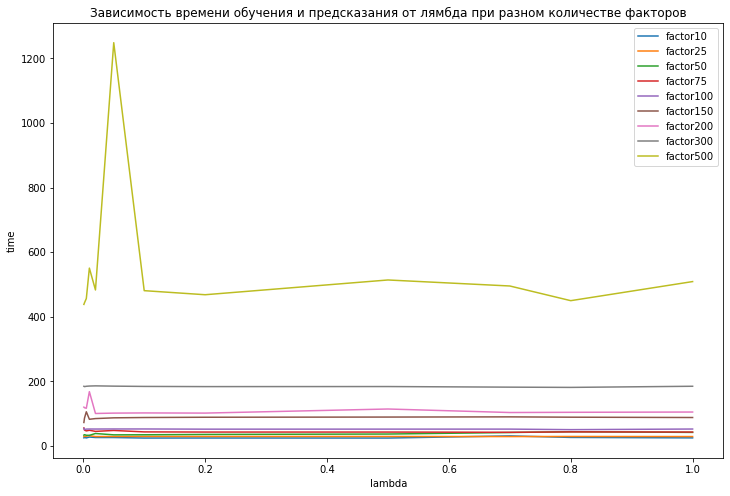

In [284]:
plt.subplots(figsize=(12,8))
plt.plot(df[df['factors']==10]['lambda'].values, df[df['factors']==10]['time'].values, label="factor10")
plt.plot(df[df['factors']==25]['lambda'].values, df[df['factors']==25]['time'].values, label="factor25")
plt.plot(df[df['factors']==50]['lambda'].values, df[df['factors']==50]['time'].values, label="factor50")
plt.plot(df[df['factors']==75]['lambda'].values, df[df['factors']==75]['time'].values, label="factor75")
plt.plot(df[df['factors']==100]['lambda'].values, df[df['factors']==100]['time'].values, label="factor100")
plt.plot(df[df['factors']==150]['lambda'].values, df[df['factors']==150]['time'].values, label="factor150")
plt.plot(df[df['factors']==200]['lambda'].values, df[df['factors']==200]['time'].values, label="factor200")
plt.plot(df[df['factors']==300]['lambda'].values, df[df['factors']==300]['time'].values, label="factor300")
plt.plot(df[df['factors']==500]['lambda'].values, df[df['factors']==500]['time'].values, label="factor500")
plt.title('Зависимость времени обучения и предсказания от лямбда при разном количестве факторов')
plt.xlabel('lambda')
plt.ylabel('time')
plt.legend()
plt.show()

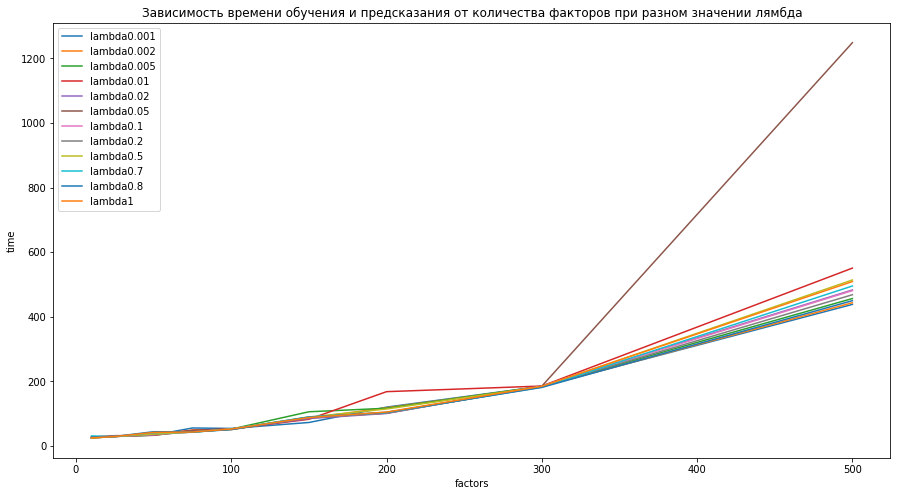

In [292]:
plt.subplots(figsize=(15,8))
plt.plot(df[df['lambda']==0.001]['factors'].values, df[df['lambda']==0.001]['time'].values, label="lambda0.001")
plt.plot(df[df['lambda']==0.002]['factors'].values, df[df['lambda']==0.002]['time'].values, label="lambda0.002")
plt.plot(df[df['lambda']==0.005]['factors'].values, df[df['lambda']==0.005]['time'].values, label="lambda0.005")
plt.plot(df[df['lambda']==0.01]['factors'].values, df[df['lambda']==0.01]['time'].values, label="lambda0.01")
plt.plot(df[df['lambda']==0.02]['factors'].values, df[df['lambda']==0.02]['time'].values, label="lambda0.02")
plt.plot(df[df['lambda']==0.05]['factors'].values, df[df['lambda']==0.05]['time'].values, label="lambda0.05")
plt.plot(df[df['lambda']==0.1]['factors'].values, df[df['lambda']==0.1]['time'].values, label="lambda0.1")
plt.plot(df[df['lambda']==0.2]['factors'].values, df[df['lambda']==0.2]['time'].values, label="lambda0.2")
plt.plot(df[df['lambda']==0.5]['factors'].values, df[df['lambda']==0.5]['time'].values, label="lambda0.5")
plt.plot(df[df['lambda']==0.7]['factors'].values, df[df['lambda']==0.7]['time'].values, label="lambda0.7")
plt.plot(df[df['lambda']==0.8]['factors'].values, df[df['lambda']==0.8]['time'].values, label="lambda0.8")
plt.plot(df[df['lambda']==1]['factors'].values, df[df['lambda']==1]['time'].values, label="lambda1")
plt.title('Зависимость времени обучения и предсказания от количества факторов при разном значении лямбда')
plt.xlabel('factors')
plt.ylabel('time')
plt.legend()
plt.show()

In [ ]:
вывод: время обучения + предсказаний зависит от количества факторов - 
    чем больше факторов - тем больше времени нужно на обучение и предсказание
    время обучения + предсказаний слабо зависит от значений лямбда(есть небольшое увелчение с ростом параметра)
    и есть один гарфик при lambda=0.05, где время увеличилось в 2 раза (почему не знаю)
немного не так посчитала время - вместо только обучения - обучение с предсказанием, но переделывать не стала, так как слишком долго считалось

In [302]:
df_new = df[df['lambda']==0.7]

In [303]:
df_new.head(2)

,factors,lambda,time,prec_train,prec_test
9,10,0.7,30.443389,0.518768,0.159452
21,25,0.7,28.389095,0.531733,0.159452


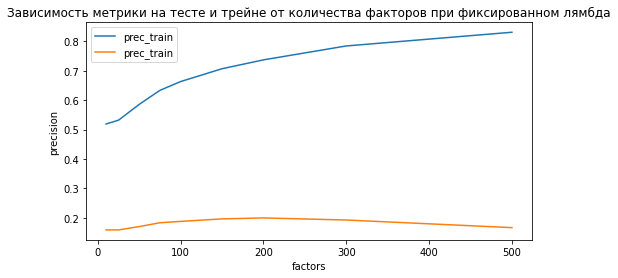

In [304]:
plt.subplots(figsize=(8,4))
plt.plot(df_new['factors'], df_new['prec_train'], label = "prec_train")
plt.plot(df_new['factors'], df_new['prec_test'], label = "prec_train")

plt.title('Зависимость метрики на тесте и трейне от количества факторов при фиксированном лямбда')
plt.xlabel('factors')
plt.ylabel('precision')
plt.legend()
plt.show()

In [305]:
df_new = df[df['lambda']==0.05]

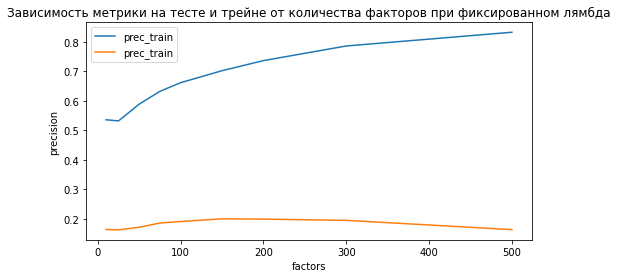

In [306]:
plt.subplots(figsize=(8,4))
plt.plot(df_new['factors'], df_new['prec_train'], label = "prec_train")
plt.plot(df_new['factors'], df_new['prec_test'], label = "prec_train")

plt.title('Зависимость метрики на тесте и трейне от количества факторов при фиксированном лямбда')
plt.xlabel('factors')
plt.ylabel('precision')
plt.legend()
plt.show()

In [307]:
df_new = df[df['factors']==150]

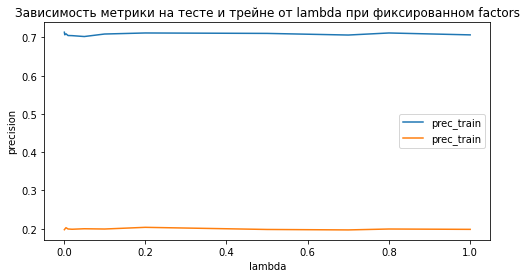

In [309]:
plt.subplots(figsize=(8,4))
plt.plot(df_new['lambda'], df_new['prec_train'], label = "prec_train")
plt.plot(df_new['lambda'], df_new['prec_test'], label = "prec_train")

plt.title('Зависимость метрики на тесте и трейне от lambda при фиксированном factors')
plt.xlabel('lambda')
plt.ylabel('precision')
plt.legend()
plt.show()

In [310]:
start = time.time()
        
        
model = AlternatingLeastSquares(factors=200, 
                                regularization=4,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  show_progress=True)

result['als_bm251'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result_train['als_bm251'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))        



r_test = result.apply(lambda row: precision_at_k(row['als_bm251'], row['actual']), axis=1).mean()
r_train = result_train.apply(lambda row: precision_at_k(row['als_bm251'], row['actual']), axis=1).mean()
        
        
stop = time.time()
duration = stop - start

In [312]:
print(r_test)

0.20519098922624882


 Вывод - есть значегие факторов при котором precision достигает большего значения - в районе 100- 300 
 При больших значениях факторов модель переобучается
 Изменение лямбды от 0 до 1 не сильно изменило результат(точечно проверила при lambda = 4- результат такой же как и при меньше 1)
 

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!